# PHYS 325 Scientific Computing -- Fall 2018

## 3.3 Molecular dynamics simulations

Good references for this chapter:

- "Computational Physics" by Mark Newman, section 8.5
- "Computational Physics" by Giordano and Nakanishi, chapter 9
- these lecture notes: http://cms.sjtu.edu.cn/doc/reading/md/A_Molecular_Dynamics_Primer_(Ercolessi).pdf

Molecular dynamics simulates Newton's equations for the classical many-body problem

- (bio)molecules
- chemical reactions
- physics of atoms
- materials
- galaxies

Possible questions:

- nature of the melting transition
- rate of equilibration after sudden parameter changes
- rate of diffusion

Molecular dynamics is complementary to Monte Carlo:

- Monte Carlo is for equilibrium properties of a system in contact with a heat bath
- cannot study approach to equilibrium because dynamics is governed by the update rules
- different methods will result in different dynamics (example: Metropolis vs. cluster updates for Ising model)

Molecular dynamics allows us to **directly simulate dynamics**!

- access to all quantities during time-evolution
- system can be highly non-equilibrium

Conserved quantities (microcanonical ensemble):

- number of particles => particle-based simulation (no QM wavefunctions or statistical density functions)
- total energy
- volume
- total momentum if forces absent
- angular momentum if no torque

Two steps:

- atoms move freely in a potential
- atoms occasionally collide with each other

### 3.3.1 Verlet algorithm

> Atoms moving in a potential

- potential $V(\mathbf{r})\Rightarrow$ force $\mathbf{F}(\mathbf{r}) = -\nabla V(\mathbf{r})$
- Newton's second law:

  $$\frac{d^2\mathbf{r}}{dt^2} = \frac{d\mathbf{v}}{dt} = \mathbf{a} = \frac{1}{m}\mathbf{F}(\mathbf{r})$$

- each atom is governed by these equations
- solve this (very large) system of ODEs using the Verlet algorithm:

  $$
  \begin{aligned}
  \mathbf{r}_{n+1} &\simeq 2\mathbf{r}_n - \mathbf{r}_{n-1} +\mathbf{a}_n\Delta t^2 \\
  \mathbf{v}_n &\simeq \frac{1}{2\Delta t}(\mathbf{r}_{n+1}-\mathbf{r}_{n-1})
  \end{aligned}
  $$
  
- the derivation is similar to Runge-Kutta:

  $$
  \begin{aligned}
  \mathbf{r}(t_n+\Delta t) & = \mathbf{r}(t_n) + \frac{d\mathbf{r}}{dt}\Delta t + \frac{1}{2}\frac{d^2\mathbf{r}}{dt^2}\Delta t^2 +\frac{1}{6}\frac{d^3\mathbf{r}}{dt^3}\Delta t^3+\ldots\\
  \mathbf{r}(t_n-\Delta t) & = \mathbf{r}(t_n) -\frac{d\mathbf{r}}{dt}\Delta t+ \frac{1}{2}\frac{d^2\mathbf{r}}{dt^2}\Delta t^2 -\frac{1}{6}\frac{d^3\mathbf{r}}{dt^3}\Delta t^3+\ldots
  \end{aligned}
  $$
  
  adding these two equations we get
  
  $$\mathbf{r}_{n+1} = 2\mathbf{r}_n -\mathbf{r}_{n-1}+ \frac{d^2\mathbf{r}}{dt^2}\Delta t^2+\mathcal{O}(\Delta t^2)$$
  
  where the second derivative is the acceleration determined by the potential
  
- the advantage of Verlet over Runge-Kutta is that it **conserves energy**

- small disadvantage: needs more than just the initial condition to start ($\mathbf{r}_{n+1}$ depends on both $\mathbf{r}_n$ and $\mathbf{r}_{n-1}$) 

- velocity is not needed to update $\mathbf{r}$

More common variation:

#### Velocity Verlet algorithm

$$
\begin{aligned}
\mathbf{v}(t_{n+1/2}) &= \mathbf{v}(t_n) +\mathbf{a}(t_n)\Delta t/2 \\
\mathbf{r}(t_{n+1}) &= \mathbf{r}(t_n) +\mathbf{v}(t_{n+1/2})\Delta t\\
\mathbf{v}(t_{n+1}) &= \mathbf{v}(t_{n+1/2}) +\mathbf{a}(t_{n+1})\Delta t/2
\end{aligned}
$$

- uses both positions and velocities
- calculate velocity half-way along time step
- note that acceleration is evaluated first at $t_n$ and then at $t_{n+1}$ (the latter can be reused in the following step)
- this is also equivalent to the leap-frog algorithm

**Example**

Reminder: harmonic oscillator $\frac{d^2\theta(t)}{dt^2} + \frac{g}{L}\sin(\theta(t))=0$ with Runge-Kutta

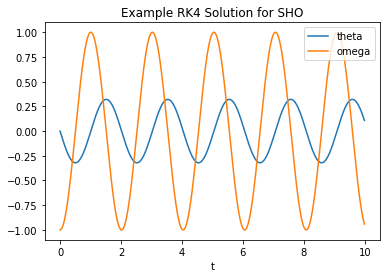

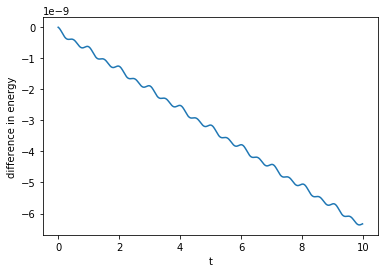

In [9]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

def f(r, t, omegasqr):
    theta=r[0]
    omega=r[1] 
    dtheta = omega
    domega = -omegasqr*np.sin(theta)
    return np.array([dtheta,domega],float)  
    
# keep track also of the total energy (assuming unit mass)
def energy(r):
    theta=r[0]
    omega=r[1]
    return omega**2/2 - g/L*np.cos(theta)

start = 0.0
end = 10.0
numSteps = 1000
stepSize = (end-start)/numSteps

g=9.8             # physical and system constants
L=1.0
omegasqr=g/L

tpoints = np.arange(start,end,stepSize)
omegapts = []
thetapts = []
energypts = []
# initial conditions for omega and theta, summarized in vector r
r = np.array([0.0,-1.0],float)   

# all steps are as normal RK4, but vector valued quantities used
for t in tpoints:
    thetapts.append(r[0])
    omegapts.append(r[1])
    energypts.append(energy(r))

    k1 = stepSize*f(r,t,omegasqr)
    k2 = stepSize*f(r+0.5*k1,t+0.5*stepSize,omegasqr)
    k3 = stepSize*f(r+0.5*k2,t+0.5*stepSize,omegasqr)
    k4 = stepSize*f(r+k3,t+stepSize,omegasqr)
    r += (k1+2.*k2+2.*k3+k4)/6

plt.plot(tpoints,thetapts,label='theta')
plt.plot(tpoints,omegapts,label='omega')
plt.title("Example RK4 Solution for SHO")
plt.xlabel("t")
plt.legend(loc='upper right')
plt.show()

plt.plot(tpoints,energypts-energypts[0])
plt.ylabel("difference in energy")
plt.xlabel("t")
plt.show()

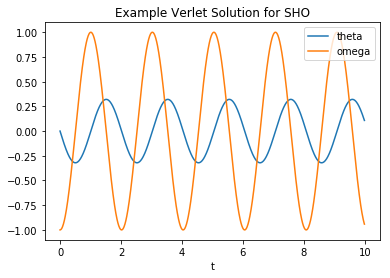

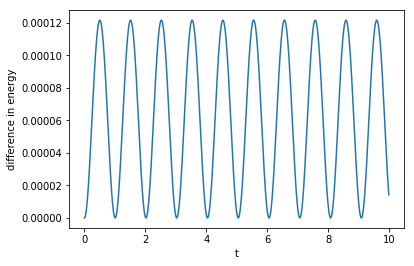

In [13]:
# same with Verlet algorithm

omegapts = []
thetapts = []
energypts = []

def acceleration(theta):
    return -omegasqr*np.sin(theta)

# initial conditions
r = np.array([0.0,-1.0],float) 
current_accel = acceleration(r[0])

for t in tpoints:
    thetapts.append(r[0])
    omegapts.append(r[1])
    energypts.append(energy(r))
    
    r[1] += current_accel*stepSize/2      # update velocity half-way, acceleration saved from before
    r[0] += r[1]*stepSize
    current_accel = acceleration(r[0])    # update acceleration
    r[1] += current_accel*stepSize/2      # update velocity to the end of time step
    
plt.plot(tpoints,thetapts,label='theta')
plt.plot(tpoints,omegapts,label='omega')
plt.title("Example Verlet Solution for SHO")
plt.xlabel("t")
plt.legend(loc='upper right')
plt.show()

plt.plot(tpoints,energypts-energypts[0])
plt.ylabel("difference in energy")
plt.xlabel("t")
plt.show()

### 3.3.2 Collisions between atoms

- typically only consider two-body collisions (most relevant for sufficiently dilute systems)
- need to check which pairs of atoms can scatter

#### Cell lists

checking all pairs of particles is extremely inefficient!

$N$ particles => $\mathcal{O}(N^2)$ pairs

most pairs are too far away to interact with each other!

- divide the domain into cells
- cell edge length $\geq$ cut-off radius of the interaction potential
- compute the interaction between the particle and all particles in the same and in neighboring cells
- reduces computational cost to $\mathcal{O}(N)$
- be careful with long-range interactions (or low numbers of particles) where this can actually be less efficient

![Cell list](images/CellLists.png)

- be careful with periodic boundary conditions!
- can wrap the simulation box in an additional layer of cells (shaded orange in the picture) containing periodic copies (sometimes called "ghosts") of the boundary cells (blue particles in the picture)

![Cell list for periodic boundary conditions](images/CellLists_Ghosts.png)

Images by Pedro Gonnet CC BY 3.0 from this [Wikipedia article](https://en.wikipedia.org/wiki/Cell_lists)

#### Van der Waals force

- force between neutral atoms at large separation
- weak attraction due to transient electric dipole moments of two atoms
- attractive potential $\propto r^{-6}$
- at short distances there is also Pauli repulsion between electron clouds
- *estimate* repulsion term as $\propto r^{-12}$

  => **Lennard-Jones potential**:

  $$V(r) = 4\epsilon\left[\left(\frac{\sigma}{r}\right)^{12}-\left(\frac{\sigma}{r}\right)^6\right]$$
  
  where $\epsilon$ and $\sigma$ are constants that set energy and distance scales
  
- force between atoms is

  $$\mathbf{F} =-\nabla V(r) = -\frac{\mathbf{r}}{r}\frac{dV}{dr}=-24\epsilon\frac{\mathbf{r}}{r^2}\left[2\left(\frac{\sigma}{r}\right)^{12}-\left(\frac{\sigma}{r}\right)^6\right]$$

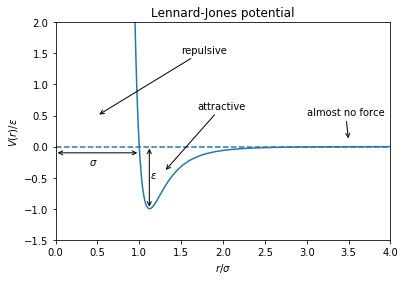

In [42]:
distance = np.arange(0.5, 4, 0.01)
plt.plot(distance, 4*(distance**(-12) - distance**(-6)) )
plt.xlim(0,4)
plt.ylim(-1.5,2)
plt.axhline(0, linestyle = '--')
plt.xlabel(r"$r/\sigma$")
plt.ylabel(r"$V(r)/\epsilon$")
plt.title("Lennard-Jones potential")

plt.annotate('attractive', xy=(1.3, -0.4), xytext=(1.7, 0.6),\
             arrowprops=dict(arrowstyle="->"))
plt.annotate('repulsive', xy=(0.5, 0.5), xytext=(1.5, 1.5),\
             arrowprops=dict(arrowstyle="->"))
plt.annotate('almost no force', xy=(3.5, 0.1), xytext=(3.0, 0.5),\
             arrowprops=dict(arrowstyle="->"))
plt.annotate('', xy=(0., -0.1), xytext=(1.0, -0.1),\
             arrowprops=dict(arrowstyle="<->"))
plt.text(0.4, -0.3, r'$\sigma$')
plt.annotate('', xy=(1.12, -1.), xytext=(1.12, 0.),\
             arrowprops=dict(arrowstyle="<->"))
plt.text(1.13, -0.5, r'$\epsilon$')

plt.show()

**Example:** Simulation for Argon atoms under the Lennard-Jones potential

- for a liquid/gas it is common to start from a "solid" lattice, and letting the structure melt 
- alternative is to place atoms randomly (uniformly or according to some distribution)
- eventually the system will equilibrate on its own

In [560]:
import numpy as np
from scipy.constants import k, u

# initial system setup
atomsPerDim = 4
dim = 3
Natoms = atomsPerDim**dim

# parameters all in SI units
temperature = 119.8         # in Kelvin
epsilon = temperature*k     # 119.8 Kelvin times Boltzmann constant
sigma = 3.405e-10           # in meters
mass = 39.948*u             # 39.948 atomic units

Nsteps =  10000
dt = 1e-15                  # 1 femtosecond time step

x = np.zeros( (dim, Natoms, Nsteps), float)   # all positions of atoms
v = np.zeros( (dim, Natoms, Nsteps), float)   # all velocities of atoms
a = np.zeros( (dim, Natoms, Nsteps), float)   # all accelerations of atoms

# initial atom placement on a square grid
space = 3.5*sigma           # average spacing between particles
L = space*atomsPerDim       # edge length of entire square  
offset = space/2.           # slightly offset particles from edge

xvals = np.linspace(offset, L-offset, atomsPerDim)

# find grid position of each atom in 3d
for i in range(atomsPerDim): 
    for j in range(atomsPerDim):     
        for h in range(atomsPerDim):
            numberAtom = atomsPerDim*atomsPerDim*h + atomsPerDim*j + i
            x[0, numberAtom, 0] = xvals[i]
            x[1, numberAtom, 0] = xvals[j]
            x[2, numberAtom, 0] = xvals[h]
            
# keep track of total momentum
vtotal = np.zeros(dim)  

# Gaussian (Maxwell-Boltzmann) velocity distribution        
for d in range(dim):
    for i in range(Natoms):
        v[d, i, 0] = np.random.normal(0, np.sqrt(temperature*k/mass))
        vtotal[d] += v[d, i, 0]

# total momentum should be zero (flying ice cube artefact)
for d in range(dim):
    for i in range(Natoms):
        v[d, i, 0] -= vtotal[d]/Natoms

# initally particles are placed far enough apart
# that there is essentially no force between them

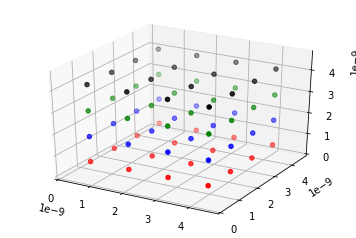

In [555]:
%matplotlib inline
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# plot initial configuration
fig = plt.figure()
atomsPlane = atomsPerDim*atomsPerDim
colorSeq = ['r', 'b', 'g', 'k']

ax = fig.gca(projection='3d')
for i in range(atomsPerDim):
    ax.scatter(x[0, i*atomsPlane:(i+1)*atomsPlane, 0],\
               x[1, i*atomsPlane:(i+1)*atomsPlane, 0],\
               x[2, i*atomsPlane:(i+1)*atomsPlane, 0], c = colorSeq[i])

ax.set_xlim(0, L)
ax.set_ylim(0, L)
ax.set_zlim(0, L)
plt.show()

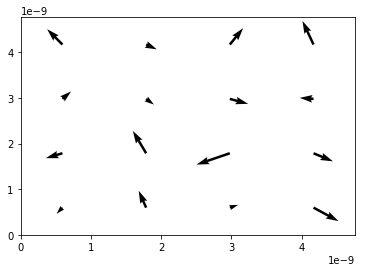

In [563]:
# plot initial configuration and velocities (one of the atom "planes", projection)
plt.quiver(x[0, :atomsPlane, 0], x[1, :atomsPlane, 0], v[0, :atomsPlane, 0], v[1, :atomsPlane, 0])
plt.xlim(0, L)
plt.ylim(0, L)
plt.show()

In [564]:
# velocity Verlet algorithm
for i in range(Nsteps-1):
    # propagate each atom based on current acceleration
    # remember that initial accelerations are zero (particles far apart)
    for n in range(Natoms):
        for d in range(dim):
            v[d, n, i+1] = v[d, n, i] + a[d, n, i]*dt/2.   # velocity only updated half-way
            x[d, n, i+1] = x[d, n, i] + v[d, n, i+1]*dt
        
            # check if particles have left the box
            # periodic boundary conditions: re-introduce them on the other side        
            if x[d, n, i+1] > L:
                x[d, n, i+1] -= L
                #x[d, n, i+1] -= L*int(x[d, n, i+1]/L)
            if x[d, n, i+1] < 0:
                #x[d, n, i+1] += L*int( abs(x[d, n, i+1]/L) + 1)
                x[d, n, i+1] += L
        
    # loop through all pairs of atoms     
    for n in range(Natoms):
        
        # update accelerations
        # determined by Lennard-Jones potential of all other atoms
        # we are not using the cell list here because we have few particles
        for m in range(n+1, Natoms): 
            
            # calculate the distance between atoms
            relativeCoord = np.zeros(dim)
            
            for d in range(dim):

                dx = x[d, n, i+1] - x[d, m, i+1]
                # account for "ghosts" due to periodic boundary conditions
                # always interact with closer image
                if dx > L/2:
                    dx -= L
                elif dx < -L/2:
                    dx += L

                relativeCoord[d] = dx
                
            distance = np.sqrt( np.sum(relativeCoord**2) )
            
            # limit the approach of particles to avoid divergence at zero
            if distance < 0.8*sigma:
                distance = 0.8*sigma
            
            # cut off potential at large distances, for efficiency
            if distance > 3.0*sigma:
                continue  
            
            # acceleration scalar part
            acceleration = -24.*epsilon*(2.*sigma**12/distance**14 - sigma**6/distance**8)/mass
            
            for d in range(dim):
                
                # acceleration of atom n due to atom m
                a[d, n, i+1] += acceleration*relativeCoord[d]
                # acceleration of atom m due to atom n (opposite direction)
                a[d, m, i+1] -= acceleration*relativeCoord[d]

    # finish updating velocity to the end of the time step
    for n in range(Natoms):
        for d in range(dim):
            v[d, n, i+1] += a[d, n, i+1]*dt/2.

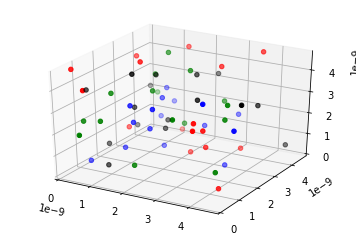

In [565]:
fig = plt.figure()

#final positions
ax = fig.gca(projection='3d')
for i in range(atomsPerDim):
    ax.scatter(x[0, i*atomsPlane:(i+1)*atomsPlane, -1],\
               x[1, i*atomsPlane:(i+1)*atomsPlane, -1],\
               x[2, i*atomsPlane:(i+1)*atomsPlane, -1], c = colorSeq[i])
ax.set_xlim(0, L)
ax.set_ylim(0, L)
ax.set_zlim(0, L)
plt.show()

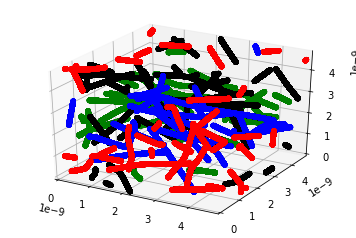

In [566]:
# atom trajectories
fig = plt.figure()

ax = fig.gca(projection='3d')
for i in range(atomsPerDim):
    ax.scatter(x[0, i*atomsPlane:(i+1)*atomsPlane, :],\
               x[1, i*atomsPlane:(i+1)*atomsPlane, :],\
               x[2, i*atomsPlane:(i+1)*atomsPlane, :], c = colorSeq[i])
ax.set_xlim(0, L)
ax.set_ylim(0, L)
ax.set_zlim(0, L)
plt.show()

Numerical packages:

- [ESPResSo](http://espressomd.org/wordpress/): molecular dynamics for soft matter research
- [HOOMD-blue](http://glotzerlab.engin.umich.edu/hoomd-blue/): general-purpose particle simulation toolkit
- [CP2K](https://www.cp2k.org/): molecular dynamics for quantum chemistry and solid state physics

... and many more

#### Scattering cross section

Quantum mechanical scattering theory

- assume elastic and non-relativistic collisions
- go into inertial frame of one of the particles
- spherically symmetric scattering potential
- the other particle is deflected in this potential
- the **cross section** of the scattering process is the area within which the particles must meet in order to scatter
     - the larger the cross section the more likely scattering occurs
     - for hard spheres it is directly related to the size of the spheres
     
       ![hard spheres cross section](images/CrossSection.png)
       
       Image source: [Wikipedia](https://en.wikipedia.org/wiki/Cross_section_(physics))
     
     - for a scattering potential the cross section is given by the properties of the potential
     - the cross section can depend on the relative momentum of the particles or on the scattering direction (=> differential cross section)
     
Cross section for a Maxwell-Boltzmann gas:

$$\sigma = 4\pi a^2$$

- $a$ is the so-called s-wave **scattering length**
- the scattering length is a property of the interaction potential
- all relevant (low-energy) information about the interaction is contained in $a$

More precise formula:

$$\sigma = \frac{4\pi a^2}{1+ a^2 p_{\rm rel}^2/4},$$

where $p_{\rm rel}$ is the relative momentum of the two particles

### Research application: bouncing Fermi clouds experiment

[Ariel Sommer, Mark Ku, Giacomo Roati & Martin W. Zwierlein, Nature 472, 201–204 (2011)](https://www.nature.com/articles/nature09989)

![Bouncing Fermi clouds](images/zwierlein1.png)

- two clouds of fermionic atoms (neutral lithium atoms) in a harmonic trapping potential
- the potential is elongated ("cigar shaped")

  ![clouds in the trap](images/dispclouds.png)

- two different kinds of fermions can interact with each other
- the interaction is attractive

=> we would expect the clouds to pass through each other (damped harmonic oscillator)

But if interactions are strong the clouds bounce!

We can explain this effect semi-classically with a molecular dynamics simulation!

[O. Goulko, F. Chevy and C. Lobo, Phys. Rev. Lett. 111, 190402 (2013)](https://arxiv.org/abs/1307.6395)<br>
[O. Goulko, F. Chevy and C. Lobo, New J. Phys. 14, 073036 (2012)](https://arxiv.org/abs/1201.6235)<br>
[O. Goulko, F. Chevy and C. Lobo, Phys. Rev. A 84, 051605(R) (2011)](https://arxiv.org/abs/1106.5773)<br>

- particles propagate in a harmonic potential
- collisions evaluated after every time step
   - particles must have opposite spin
   - particles must be at their closest approach during the time step
   - particles must be within cross section
   - can even account for Pauli blocking probability!
   - collisions conserve center of mass position and momentum
   - collisions conserve angular momentum (small violation of energy conservation)
   
Results:

- we can follow the dynamics of the clouds directly
- can calculate all interesting quantities
- can check when the bounce happens
- can switch on and off different parts of the model

In [1]:
from IPython.display import HTML

In [2]:
%%HTML
<video width="640" height="480" controls>
  <source src="images/Tinit0.5bounce.mp4" type="video/mp4">
</video>